In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

TensorFlow 2.x selected.
Tensorflow version: 2.1.0-rc1
GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books-data.git

Cloning into 'books-data'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 84 (delta 21), reused 63 (delta 14), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [0]:
import glob

def read_data(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books-data/kafka/"
directory2 = "books-data/shelley/"
directory3 = "books-data/defoe/"
directory4 = "books-data/plato/"
directory5 = "books-data/dumas/"

text = read_data(directory3)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 621863 characters


In [0]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove, chars_to_translate, replacement_chars):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = "".join( list( map(DataProcessor.__split_punctuation_from_sentence , text)))
		text = " ".join(text.split())
		return text
	
	@staticmethod
	def __split_punctuation_from_sentence(char):
		if (char == '.' or char == ','):
		  return (" " + char + " ")
		else:
			return (char)

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

unique_characters = sorted(list(set(text)))
print ('{} unique characters:'.format(len(unique_characters)))
print(unique_characters)

words = text.split()
print('Total words:', len(words))

vocab = sorted(set(words))
vocab_size = len(vocab)
print('Unique words:', vocab_size)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 134362
Unique words: 6359


In [0]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

word_to_indices = dict((w, i) for i, w in enumerate(vocab))
indices_to_word = dict((i, w) for i, w in enumerate(vocab))

class Dataset:
	def __init__(self):
		self.text_sequences = list()
		self.X_train = list()
		self.y_train = list()
		self.X_val = list()
		self.y_val = list()

	def make_dataset(self, words, input_sequence_length=10, output_sequence_length=1):
		sequence_length = input_sequence_length + output_sequence_length 
		tokens = self.__create_tokens(words, sequence_length)
		self.__create_training_and_validation_set(tokens)
		return self

	def __create_tokens(self, words, sequence_length):
		encoded_words = [word_to_indices[word] for word in words]
		tokens = list()
		for i in range(sequence_length, len(words)):
			line = ' '.join(words[i-sequence_length:i])
			self.text_sequences.append(line)
			tokens.append(encoded_words[i-sequence_length:i])
		return tokens

	def __create_training_and_validation_set(self, tokens):
		data = np.asarray(tokens)
		X, y = data[:,:-1], data[:,-1]
		y = np_utils.to_categorical(y, num_classes=vocab_size)
		self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

	def get_random_sequence(self):
		return self.text_sequences[randint(0, len(self.text_sequences))]
    
input_sequence_length = 10
output_sequence_length = 1
dataset = Dataset().make_dataset(words, input_sequence_length, output_sequence_length)

print('Total Sequences:',  len(dataset.text_sequences))

Using TensorFlow backend.


Total Sequences: 134351


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model.add(Embedding(vocab_size, 50, input_length=input_sequence_length))
    self.model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 50)            317950    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 100)           60400     
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 6359)              642259    
Total params: 1,101,809
Trainable params: 1,101,409
Non-trainable params: 400
____________________________________________

In [0]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, seed, words_amount):
	result = list()
	input_text = seed
	for _ in range(words_amount):
		encoded_text = [word_to_indices[word] for word in input_text.split()]
		encoded_text = pad_sequences([encoded_text], maxlen=input_sequence_length, truncating='pre')
		predictions = model.predict_classes(encoded_text, verbose=0)
		predicted_word = indices_to_word[predictions[0]]
		input_text += ' ' + predicted_word
		result.append(predicted_word)
	result = ' '.join(result).replace(" ,", ",").replace(" .", ".\n")
	return result

In [0]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    print('Generated text:')
    print(generate_text(model.model, seed=seed_for_epochs, words_amount=50))
    print()
    
text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

Checking with seed: was among them , so neither did i yet only that


In [0]:
batch_size = 64
epochs = 100
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_val, dataset.y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 107480 samples, validate on 26871 samples
Epoch 1/100

Generated text:
i had been very much as i had been to be much as i had been to be much as i had been to be much as i had been to be much as i had been to be much as i had been to be much as i had

107480/107480 - 38s - loss: 5.4886 - accuracy: 0.1584 - val_loss: 5.0168 - val_accuracy: 0.1774
Epoch 2/100

Generated text:
i had been a little way to be a little, and that i had been a little way to be a little, and that i had been a little way to be a little, and that i had been a little way to be a little,

107480/107480 - 29s - loss: 4.5878 - accuracy: 0.2011 - val_loss: 4.7783 - val_accuracy: 0.1962
Epoch 3/100

Generated text:
i had been a great deal of a great deal of.
 in the next day, i began to be very thankful for, and i had no notion of my mind, and to think of the ship, and i had made a great deal of it

107480/107480 - 28s - loss: 4.2188 - accuracy: 0.2242 - val_loss: 4.8236 - val_accuracy: 0.2003
Epoch 4/100

Gene

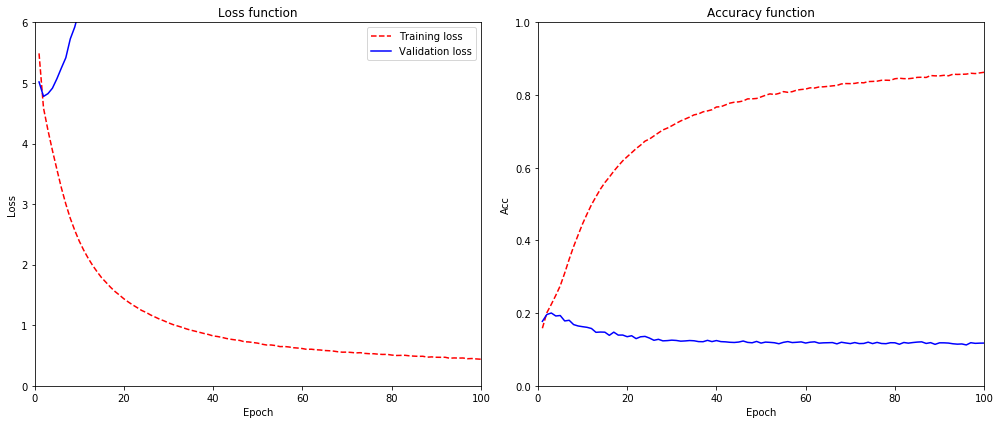

In [0]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [0]:
seed = dataset.get_random_sequence()
print("Generating with seed:",seed, "\n")
generated_text = generate_text(model.model, seed, words_amount=300)
print(generated_text)

Generating with seed: again and fetch it . having now brought all my things 

became up of my head sank into my saw of their pieces of their bones, and two who did not only quite the devil, yet he frequently got their boat, and were obliged to go away, for i might be driven here, to make the boat a cave on shore.
 here i began to take up this journey these things, without how i never wanted ventured in less able sufficient to lodge together.
 having a fair time.
 i felt all my little family, and i had much of leisure, what what i never got nimbly enough, and his down told his life than well as he, whose life i.
 once thus escaped with these hands of these month of october in the morning, to defend myself against what he were three days of death nor, in the account of my effects, or rather manner to be my money in london, he told me i would go and sit down with sigh, like all eat in which i should carry about of them and alive and spade.
 does the desires i ran bearded his men gone, and